In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image

In [2]:
# Settings
IMG_WIDTH, IMG_HEIGHT = 48, 48
NUM_CHANNELS = 1
BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 0.001
EMOTION_CLASSES = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
NUM_CLASSES = len(EMOTION_CLASSES)

np.random.seed(42)
tf.random.set_seed(42)
os.makedirs('models', exist_ok=True)

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

valid_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'split_dataset/train',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = valid_test_datagen.flow_from_directory(
    'split_dataset/val',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = valid_test_datagen.flow_from_directory(
    'split_dataset/test',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 90477 images belonging to 7 classes.
Found 30159 images belonging to 7 classes.
Found 30159 images belonging to 7 classes.


In [4]:
def resnet_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    if stride != 1:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    return x

def create_resnet(input_shape=(IMG_WIDTH, IMG_HEIGHT, NUM_CHANNELS), num_classes=NUM_CLASSES):
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
    x = resnet_block(x, 64)
    x = resnet_block(x, 128, stride=2)
    x = resnet_block(x, 256, stride=2)
    x = resnet_block(x, 512, stride=2)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

resnet_model = create_resnet()
resnet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 24, 24,    │      3,200 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 24, 24,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 24, 24,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 12, 12,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 12, 12,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 12, 12,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 12, 12,    │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 12, 12,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 12, 12,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 6, 6, 128) │     73,856 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 6, 128) │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 6, 6, 128) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 6, 6, 128) │    147,584 │ re_lu_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 6, 6, 128) │      8,320 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 6, 128) │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 4,911,751 (18.74 MB)

 Trainable params: 4,905,991 (18.71 MB)

 Non-trainable params: 5,760 (22.50 KB)

In [5]:
from tensorflow.keras.applications import MobileNetV2

def create_mobilenet_model(input_shape=(IMG_WIDTH, IMG_HEIGHT, NUM_CHANNELS), num_classes=NUM_CLASSES):
    inputs = Input(shape=input_shape)
    if NUM_CHANNELS == 1:
        x = layers.Lambda(
            lambda x: tf.image.grayscale_to_rgb(x),
            output_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
        )(inputs)
    else:
        x = inputs
    base_model = MobileNetV2(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), include_top=False, weights='imagenet')
    base_model.trainable = False  # Start with frozen base
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

mobilenet_model = create_mobilenet_model()
mobilenet_model.summary()

C:\Users\asus\AppData\Local\Temp\ipykernel_23468\2840470228.py:12: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), include_top=False, weights='imagenet')


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,621,255 (10.00 MB)

 Trainable params: 362,503 (1.38 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

In [6]:
# For ResNet
checkpoint_resnet = ModelCheckpoint(
    'models/resnet_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
early_stopping_resnet = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
reduce_lr_resnet = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# For MobileNetV2
checkpoint_mobilenet = ModelCheckpoint(
    'models/mobilenet_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
early_stopping_mobilenet = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
reduce_lr_mobilenet = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

In [7]:
# Train ResNet
history_resnet = resnet_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=EPOCHS,
    callbacks=[checkpoint_resnet, early_stopping_resnet, reduce_lr_resnet],
    verbose=1
)
pd.DataFrame(history_resnet.history).to_csv('training_history_resnet.csv', index=False)

Epoch 1/20


c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.2563 - loss: 1.8276
Epoch 1: val_accuracy improved from -inf to 0.34570, saving model to models/resnet_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 127s 87ms/step - accuracy: 0.2563 - loss: 1.8276 - val_accuracy: 0.3457 - val_loss: 1.7570 - learning_rate: 0.0010
Epoch 2/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.3446 - loss: 1.6562
Epoch 2: val_accuracy improved from 0.34570 to 0.36460, saving model to models/resnet_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 119s 84ms/step - accuracy: 0.3446 - loss: 1.6562 - val_accuracy: 0.3646 - val_loss: 1.7224 - learning_rate: 0.0010
Epoch 3/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4056 - loss: 1.5300
Epoch 3: val_accuracy improved from 0.36460 to 0.42969, saving model to models/resnet_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 118s 84ms/step - accuracy: 0.4056 - loss: 1.5300 - val_accuracy: 0.4297 - val_loss: 1.5157 - learning_rate: 0.0010
Epoch 4/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4320 - loss: 1.4710
Epoch 4: val_accuracy did not improve from 0.42969
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 123s 87ms/step - accuracy: 0.4320 - loss: 1.4710 - val_accuracy: 0.4174 - val_loss: 1.5296 - learning_rate: 0.0010
Epoch 5/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4569 - loss: 1.4155
Epoch 5: val_accuracy improved from 0.42969 to 0.49007, saving model to models/resnet_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 136s 96ms/step - accuracy: 0.4569 - loss: 1.4155 - val_accuracy: 0.4901 - val_loss: 1.3291 - learning_rate: 0.0010
Epoch 6/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.4716 - loss: 1.3819
Epoch 6: val_accuracy did not improve from 0.49007
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 134s 95ms/step - accuracy: 0.4716 - loss: 1.3819 - val_accuracy: 0.4605 - val_loss: 1.4157 - learning_rate: 0.0010
Epoch 7/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.4860 - loss: 1.3495
Epoch 7: val_accuracy improved from 0.49007 to 0.50585, saving model to models/resnet_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 128s 91ms/step - accuracy: 0.4860 - loss: 1.3495 - val_accuracy: 0.5059 - val_loss: 1.3086 - learning_rate: 0.0010
Epoch 8/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4952 - loss: 1.3279
Epoch 8: val_accuracy improved from 0.50585 to 0.52794, saving model to models/resnet_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 126s 89ms/step - accuracy: 0.4952 - loss: 1.3279 - val_accuracy: 0.5279 - val_loss: 1.2389 - learning_rate: 0.0010
Epoch 9/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5073 - loss: 1.2984
Epoch 9: val_accuracy did not improve from 0.52794
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 124s 88ms/step - accuracy: 0.5073 - loss: 1.2984 - val_accuracy: 0.5166 - val_loss: 1.2634 - learning_rate: 0.0010
Epoch 10/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5112 - loss: 1.2846
Epoch 10: val_accuracy did not improve from 0.52794
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 125s 89ms/step - accuracy: 0.5112 - loss: 1.2846 - val_accuracy: 0.5202 - val_loss: 1.2675 - learning_rate: 0.0010
Epoch 11/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5209 - loss: 1.2623
Epoch 11: val_accuracy improved from 0.52794 to 0.53321, saving model to models/resnet_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 125s 89ms/step - accuracy: 0.5209 - loss: 1.2623 - val_accuracy: 0.5332 - val_loss: 1.2338 - learning_rate: 0.0010
Epoch 12/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5266 - loss: 1.2463
Epoch 12: val_accuracy improved from 0.53321 to 0.54418, saving model to models/resnet_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 124s 88ms/step - accuracy: 0.5266 - loss: 1.2463 - val_accuracy: 0.5442 - val_loss: 1.2095 - learning_rate: 0.0010
Epoch 13/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5340 - loss: 1.2279
Epoch 13: val_accuracy improved from 0.54418 to 0.54979, saving model to models/resnet_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 128s 90ms/step - accuracy: 0.5340 - loss: 1.2279 - val_accuracy: 0.5498 - val_loss: 1.1817 - learning_rate: 0.0010
Epoch 14/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5396 - loss: 1.2152
Epoch 14: val_accuracy did not improve from 0.54979
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 139s 98ms/step - accuracy: 0.5396 - loss: 1.2152 - val_accuracy: 0.5331 - val_loss: 1.2348 - learning_rate: 0.0010
Epoch 15/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5420 - loss: 1.2078
Epoch 15: val_accuracy improved from 0.54979 to 0.57349, saving model to models/resnet_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 128s 91ms/step - accuracy: 0.5420 - loss: 1.2078 - val_accuracy: 0.5735 - val_loss: 1.1278 - learning_rate: 0.0010
Epoch 16/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5478 - loss: 1.1908
Epoch 16: val_accuracy did not improve from 0.57349
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 122s 86ms/step - accuracy: 0.5478 - loss: 1.1908 - val_accuracy: 0.5561 - val_loss: 1.1658 - learning_rate: 0.0010
Epoch 17/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5519 - loss: 1.1768
Epoch 17: val_accuracy did not improve from 0.57349
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 123s 87ms/step - accuracy: 0.5519 - loss: 1.1768 - val_accuracy: 0.5685 - val_loss: 1.1327 - learning_rate: 0.0010
Epoch 18/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5594 - loss: 1.1649
Epoch 18: val_accuracy did not improve from 0.57349
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 123s 87ms/step - accuracy: 0.5594 - loss: 1.1649 - val_accuracy: 0.5281 - val_loss: 1.2435 - learning_rat

1414/1414 ━━━━━━━━━━━━━━━━━━━━ 123s 87ms/step - accuracy: 0.5632 - loss: 1.1481 - val_accuracy: 0.5808 - val_loss: 1.1002 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 20.


In [8]:
# Stage 1: Train only the head
history_mobilenet = mobilenet_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=5,  # 5-10 epochs is typical for head training
    callbacks=[checkpoint_mobilenet, early_stopping_mobilenet, reduce_lr_mobilenet],
    verbose=1
)

# Stage 2: Unfreeze top layers and fine-tune
# Unfreeze the top N layers of MobileNetV2
N = 40  # You can experiment with this number (20-60 is common)
base_model = mobilenet_model.layers[2]  # This is the MobileNetV2 base
for layer in base_model.layers[-N:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

mobilenet_model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_mobilenet_finetune = mobilenet_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=EPOCHS,  # You can use the same or fewer epochs
    callbacks=[checkpoint_mobilenet, early_stopping_mobilenet, reduce_lr_mobilenet],
    verbose=1
)

Epoch 1/5
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2226 - loss: 2.0570
Epoch 1: val_accuracy improved from -inf to 0.31327, saving model to models/mobilenet_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 91s 62ms/step - accuracy: 0.2226 - loss: 2.0569 - val_accuracy: 0.3133 - val_loss: 1.7229 - learning_rate: 0.0010
Epoch 2/5
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2816 - loss: 1.7554
Epoch 2: val_accuracy improved from 0.31327 to 0.31921, saving model to models/mobilenet_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 88s 62ms/step - accuracy: 0.2816 - loss: 1.7554 - val_accuracy: 0.3192 - val_loss: 1.7054 - learning_rate: 0.0010
Epoch 3/5
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2945 - loss: 1.7366
Epoch 3: val_accuracy did not improve from 0.31921
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 88s 62ms/step - accuracy: 0.2945 - loss: 1.7366 - val_accuracy: 0.3123 - val_loss: 1.7090 - learning_rate: 0.0010
Epoch 4/5
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2959 - loss: 1.7356
Epoch 4: val_accuracy improved from 0.31921 to 0.32335, saving model to models/mobilenet_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 76s 54ms/step - accuracy: 0.2959 - loss: 1.7356 - val_accuracy: 0.3234 - val_loss: 1.7027 - learning_rate: 0.0010
Epoch 5/5
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2993 - loss: 1.7293
Epoch 5: val_accuracy improved from 0.32335 to 0.32504, saving model to models/mobilenet_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 79s 56ms/step - accuracy: 0.2993 - loss: 1.7293 - val_accuracy: 0.3250 - val_loss: 1.6970 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.
Epoch 1/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3090 - loss: 1.7141
Epoch 1: val_accuracy improved from 0.32504 to 0.35263, saving model to models/mobilenet_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 106s 72ms/step - accuracy: 0.3090 - loss: 1.7141 - val_accuracy: 0.3526 - val_loss: 1.6504 - learning_rate: 1.0000e-05
Epoch 2/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.3312 - loss: 1.6819
Epoch 2: val_accuracy improved from 0.35263 to 0.36235, saving model to models/mobilenet_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 102s 72ms/step - accuracy: 0.3312 - loss: 1.6819 - val_accuracy: 0.3623 - val_loss: 1.6275 - learning_rate: 1.0000e-05
Epoch 3/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3393 - loss: 1.6701
Epoch 3: val_accuracy did not improve from 0.36235
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 88s 62ms/step - accuracy: 0.3393 - loss: 1.6701 - val_accuracy: 0.3526 - val_loss: 1.6383 - learning_rate: 1.0000e-05
Epoch 4/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3459 - loss: 1.6559
Epoch 4: val_accuracy improved from 0.36235 to 0.38324, saving model to models/mobilenet_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 89s 63ms/step - accuracy: 0.3459 - loss: 1.6559 - val_accuracy: 0.3832 - val_loss: 1.5868 - learning_rate: 1.0000e-05
Epoch 5/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3572 - loss: 1.6387
Epoch 5: val_accuracy improved from 0.38324 to 0.39066, saving model to models/mobilenet_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 101s 72ms/step - accuracy: 0.3572 - loss: 1.6387 - val_accuracy: 0.3907 - val_loss: 1.5762 - learning_rate: 1.0000e-05
Epoch 6/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3602 - loss: 1.6298
Epoch 6: val_accuracy did not improve from 0.39066
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 101s 72ms/step - accuracy: 0.3602 - loss: 1.6298 - val_accuracy: 0.3563 - val_loss: 1.6357 - learning_rate: 1.0000e-05
Epoch 7/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3623 - loss: 1.6237
Epoch 7: val_accuracy improved from 0.39066 to 0.40555, saving model to models/mobilenet_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 102s 72ms/step - accuracy: 0.3623 - loss: 1.6237 - val_accuracy: 0.4056 - val_loss: 1.5494 - learning_rate: 1.0000e-05
Epoch 8/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3639 - loss: 1.6204
Epoch 8: val_accuracy did not improve from 0.40555
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 101s 72ms/step - accuracy: 0.3639 - loss: 1.6204 - val_accuracy: 0.3842 - val_loss: 1.5810 - learning_rate: 1.0000e-05
Epoch 9/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.3670 - loss: 1.6128
Epoch 9: val_accuracy did not improve from 0.40555
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 102s 72ms/step - accuracy: 0.3670 - loss: 1.6128 - val_accuracy: 0.3827 - val_loss: 1.5883 - learning_rate: 1.0000e-05
Epoch 10/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3715 - loss: 1.6068
Epoch 10: val_accuracy did not improve from 0.40555
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 97s 69ms/step - accuracy: 0.3715 - loss: 1.6068 - val_accuracy: 0.4016 - val_loss: 1.5424 - learn

1414/1414 ━━━━━━━━━━━━━━━━━━━━ 91s 64ms/step - accuracy: 0.3791 - loss: 1.5909 - val_accuracy: 0.4121 - val_loss: 1.5205 - learning_rate: 1.0000e-05
Epoch 14/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.3774 - loss: 1.5936
Epoch 14: val_accuracy improved from 0.41208 to 0.41414, saving model to models/mobilenet_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 91s 65ms/step - accuracy: 0.3774 - loss: 1.5936 - val_accuracy: 0.4141 - val_loss: 1.5219 - learning_rate: 1.0000e-05
Epoch 15/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3838 - loss: 1.5813
Epoch 15: val_accuracy did not improve from 0.41414
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 89s 63ms/step - accuracy: 0.3838 - loss: 1.5813 - val_accuracy: 0.4057 - val_loss: 1.5353 - learning_rate: 1.0000e-05
Epoch 16/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.3864 - loss: 1.5764
Epoch 16: val_accuracy did not improve from 0.41414
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 91s 64ms/step - accuracy: 0.3864 - loss: 1.5764 - val_accuracy: 0.4068 - val_loss: 1.5325 - learning_rate: 1.0000e-05
Epoch 17/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.3862 - loss: 1.5771
Epoch 17: val_accuracy did not improve from 0.41414
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 91s 64ms/step - accuracy: 0.3862 - loss: 1.5771 - val_accuracy: 0.3992 - val_loss: 1.5530 - lear

1414/1414 ━━━━━━━━━━━━━━━━━━━━ 104s 73ms/step - accuracy: 0.3917 - loss: 1.5637 - val_accuracy: 0.4206 - val_loss: 1.5024 - learning_rate: 2.0000e-06
Epoch 20/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.3964 - loss: 1.5578
Epoch 20: val_accuracy improved from 0.42057 to 0.42233, saving model to models/mobilenet_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 93s 65ms/step - accuracy: 0.3964 - loss: 1.5578 - val_accuracy: 0.4223 - val_loss: 1.4971 - learning_rate: 2.0000e-06
Restoring model weights from the end of the best epoch: 20.


472/472 ━━━━━━━━━━━━━━━━━━━━ 152s 321ms/step - accuracy: 0.5114 - loss: 1.2474
ResNet Test accuracy: 0.5821
ResNet Test loss: 1.1028
472/472 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step


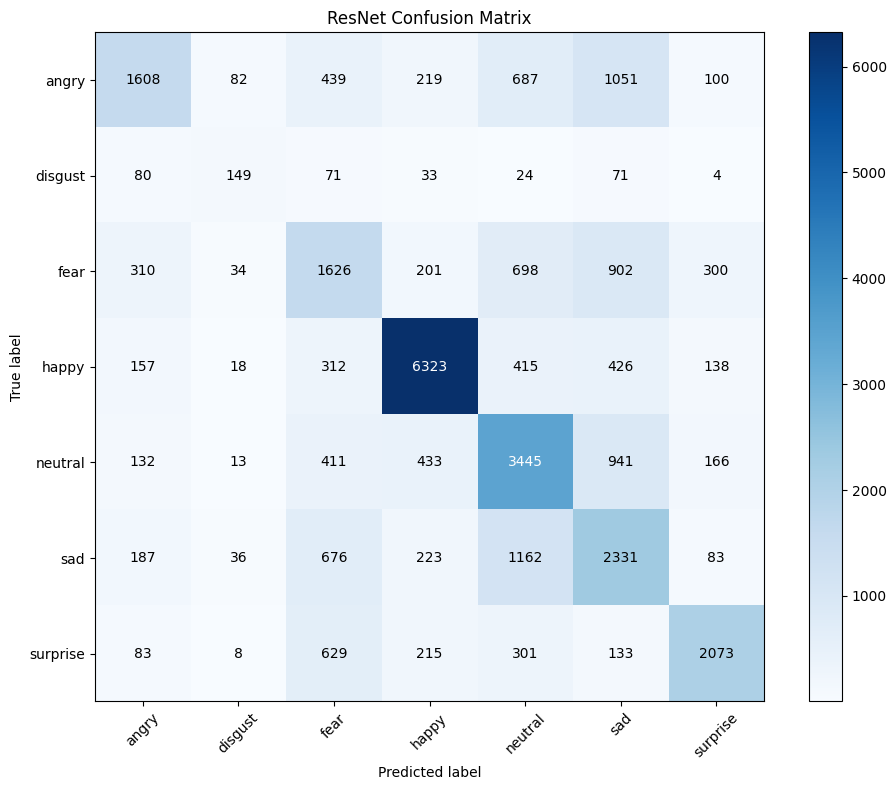


ResNet Classification Report:
              precision    recall  f1-score   support

       angry       0.63      0.38      0.48      4186
     disgust       0.44      0.34      0.39       432
        fear       0.39      0.40      0.39      4071
       happy       0.83      0.81      0.82      7789
     neutral       0.51      0.62      0.56      5541
         sad       0.40      0.50      0.44      4698
    surprise       0.72      0.60      0.66      3442

    accuracy                           0.58     30159
   macro avg       0.56      0.52      0.53     30159
weighted avg       0.60      0.58      0.58     30159



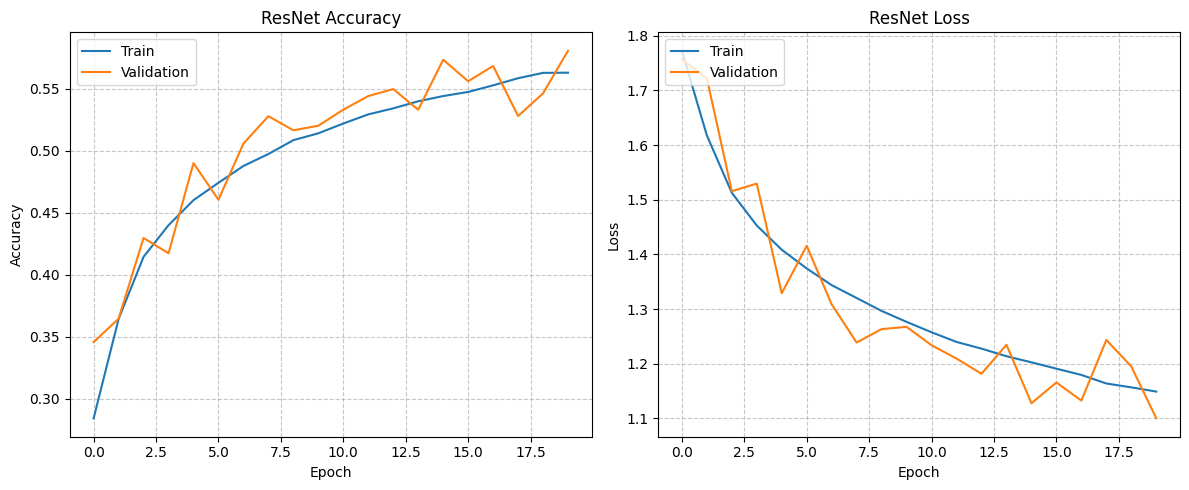

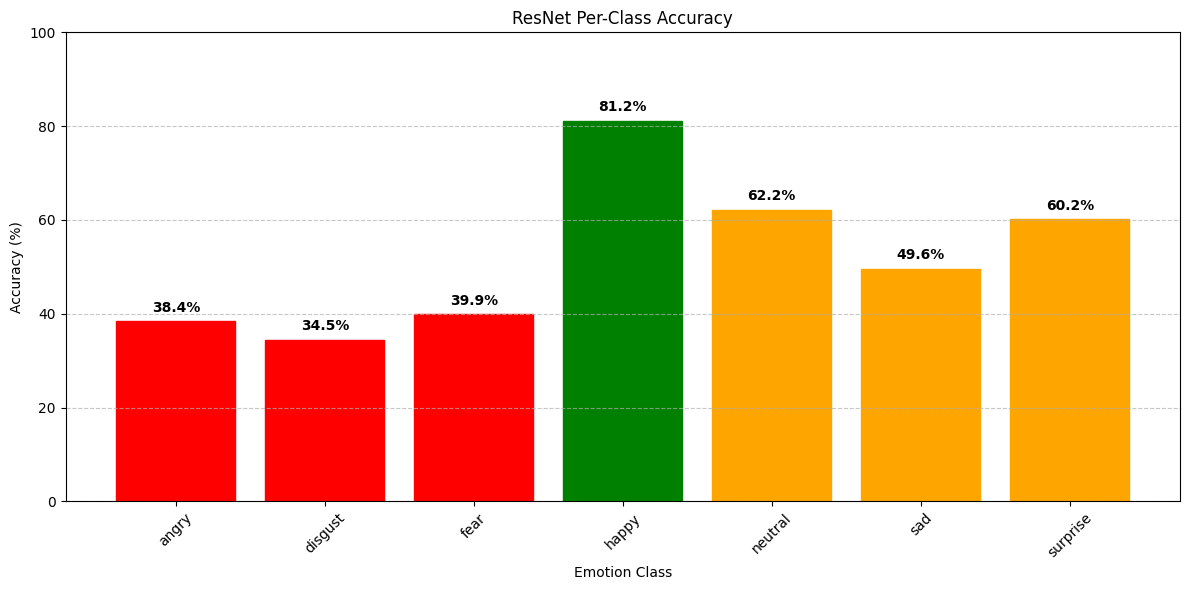

In [9]:
# Load best model
best_resnet = tf.keras.models.load_model('models/resnet_best.h5')

# Evaluate
test_loss_resnet, test_accuracy_resnet = best_resnet.evaluate(test_generator, steps=len(test_generator))
print(f"ResNet Test accuracy: {test_accuracy_resnet:.4f}")
print(f"ResNet Test loss: {test_loss_resnet:.4f}")

# Predictions
test_generator.reset()
y_pred_prob_resnet = best_resnet.predict(test_generator, steps=len(test_generator))
y_pred_resnet = np.argmax(y_pred_prob_resnet, axis=1)
y_true_resnet = test_generator.classes

# Confusion Matrix
cm_resnet = confusion_matrix(y_true_resnet, y_pred_resnet)
plt.figure(figsize=(10, 8))
plt.imshow(cm_resnet, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('ResNet Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(EMOTION_CLASSES))
plt.xticks(tick_marks, EMOTION_CLASSES, rotation=45)
plt.yticks(tick_marks, EMOTION_CLASSES)
thresh = cm_resnet.max() / 2.
for i in range(cm_resnet.shape[0]):
    for j in range(cm_resnet.shape[1]):
        plt.text(j, i, format(cm_resnet[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm_resnet[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig('confusion_matrix_resnet.png')
plt.show()

# Classification Report
print("\nResNet Classification Report:")
print(classification_report(y_true_resnet, y_pred_resnet, target_names=EMOTION_CLASSES))

# Accuracy/Loss Curves
history_df_resnet = pd.read_csv('training_history_resnet.csv')
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df_resnet['accuracy'])
plt.plot(history_df_resnet['val_accuracy'])
plt.title('ResNet Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.plot(history_df_resnet['loss'])
plt.plot(history_df_resnet['val_loss'])
plt.title('ResNet Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('training_history_resnet.png')
plt.show()

# Per-class accuracy
class_accuracy_resnet = np.diag(cm_resnet) / np.sum(cm_resnet, axis=1)
plt.figure(figsize=(12, 6))
bars = plt.bar(EMOTION_CLASSES, class_accuracy_resnet * 100)
for i, bar in enumerate(bars):
    if class_accuracy_resnet[i] >= 0.75:
        bar.set_color('green')
    elif class_accuracy_resnet[i] <= 0.4:
        bar.set_color('red')
    else:
        bar.set_color('orange')
plt.xlabel('Emotion Class')
plt.ylabel('Accuracy (%)')
plt.title('ResNet Per-Class Accuracy')
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(class_accuracy_resnet):
    plt.text(i, v*100 + 2, f'{v*100:.1f}%', ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig('per_class_accuracy_resnet.png')
plt.show()

943/943 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.3138 - loss: 1.7058
MobileNetV2 Test accuracy: 0.4205
MobileNetV2 Test loss: 1.5031
943/943 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step

MobileNetV2 Classification Report:
              precision    recall  f1-score   support

       angry       0.35      0.21      0.27      4186
     disgust       0.67      0.00      0.01       432
        fear       0.35      0.06      0.10      4071
       happy       0.56      0.67      0.61      7789
     neutral       0.33      0.59      0.42      5541
         sad       0.35      0.22      0.27      4698
    surprise       0.42      0.60      0.49      3442

    accuracy                           0.42     30159
   macro avg       0.43      0.34      0.31     30159
weighted avg       0.41      0.42      0.38     30159



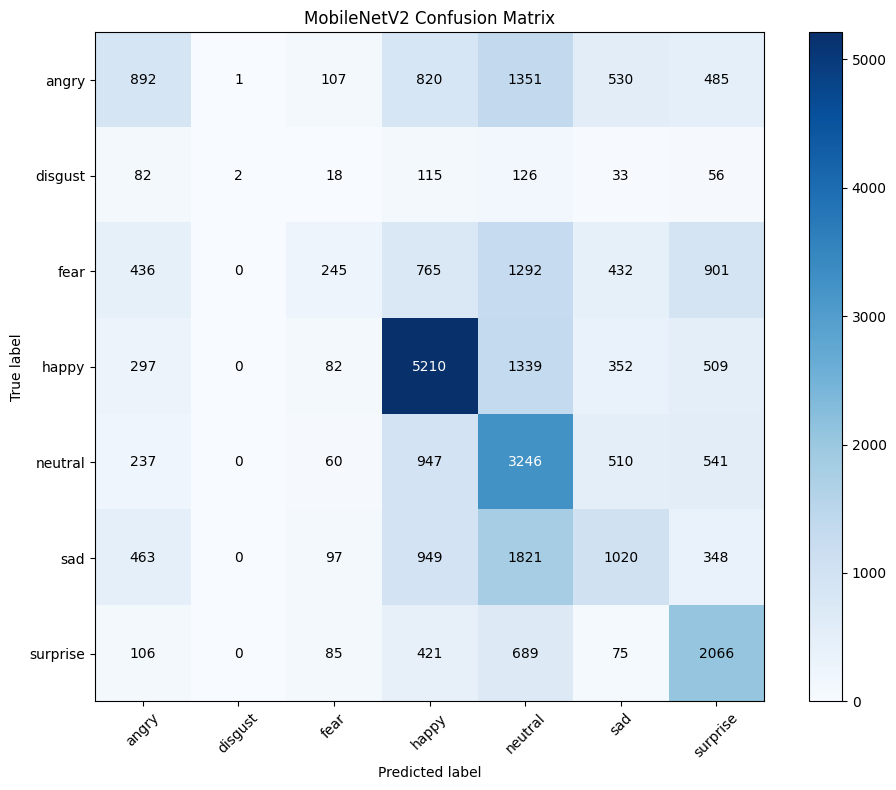

In [18]:
# Evaluate on test_generator
test_loss_mobilenet, test_accuracy_mobilenet = mobilenet_model.evaluate(test_generator, steps=len(test_generator))
print(f"MobileNetV2 Test accuracy: {test_accuracy_mobilenet:.4f}")
print(f"MobileNetV2 Test loss: {test_loss_mobilenet:.4f}")

# Predictions
test_generator.reset()
y_pred_prob_mobilenet = mobilenet_model.predict(test_generator, steps=len(test_generator))
y_pred_mobilenet = np.argmax(y_pred_prob_mobilenet, axis=1)
y_true_mobilenet = test_generator.classes

cm_mobilenet = confusion_matrix(y_true_mobilenet, y_pred_mobilenet)
print("\nMobileNetV2 Classification Report:")
print(classification_report(y_true_mobilenet, y_pred_mobilenet, target_names=EMOTION_CLASSES))

plt.figure(figsize=(10, 8))
plt.imshow(cm_mobilenet, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('MobileNetV2 Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(EMOTION_CLASSES))
plt.xticks(tick_marks, EMOTION_CLASSES, rotation=45)
plt.yticks(tick_marks, EMOTION_CLASSES)
thresh = cm_mobilenet.max() / 2.
for i in range(cm_mobilenet.shape[0]):
    for j in range(cm_mobilenet.shape[1]):
        plt.text(j, i, format(cm_mobilenet[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm_mobilenet[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig('confusion_matrix_mobilenet.png')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


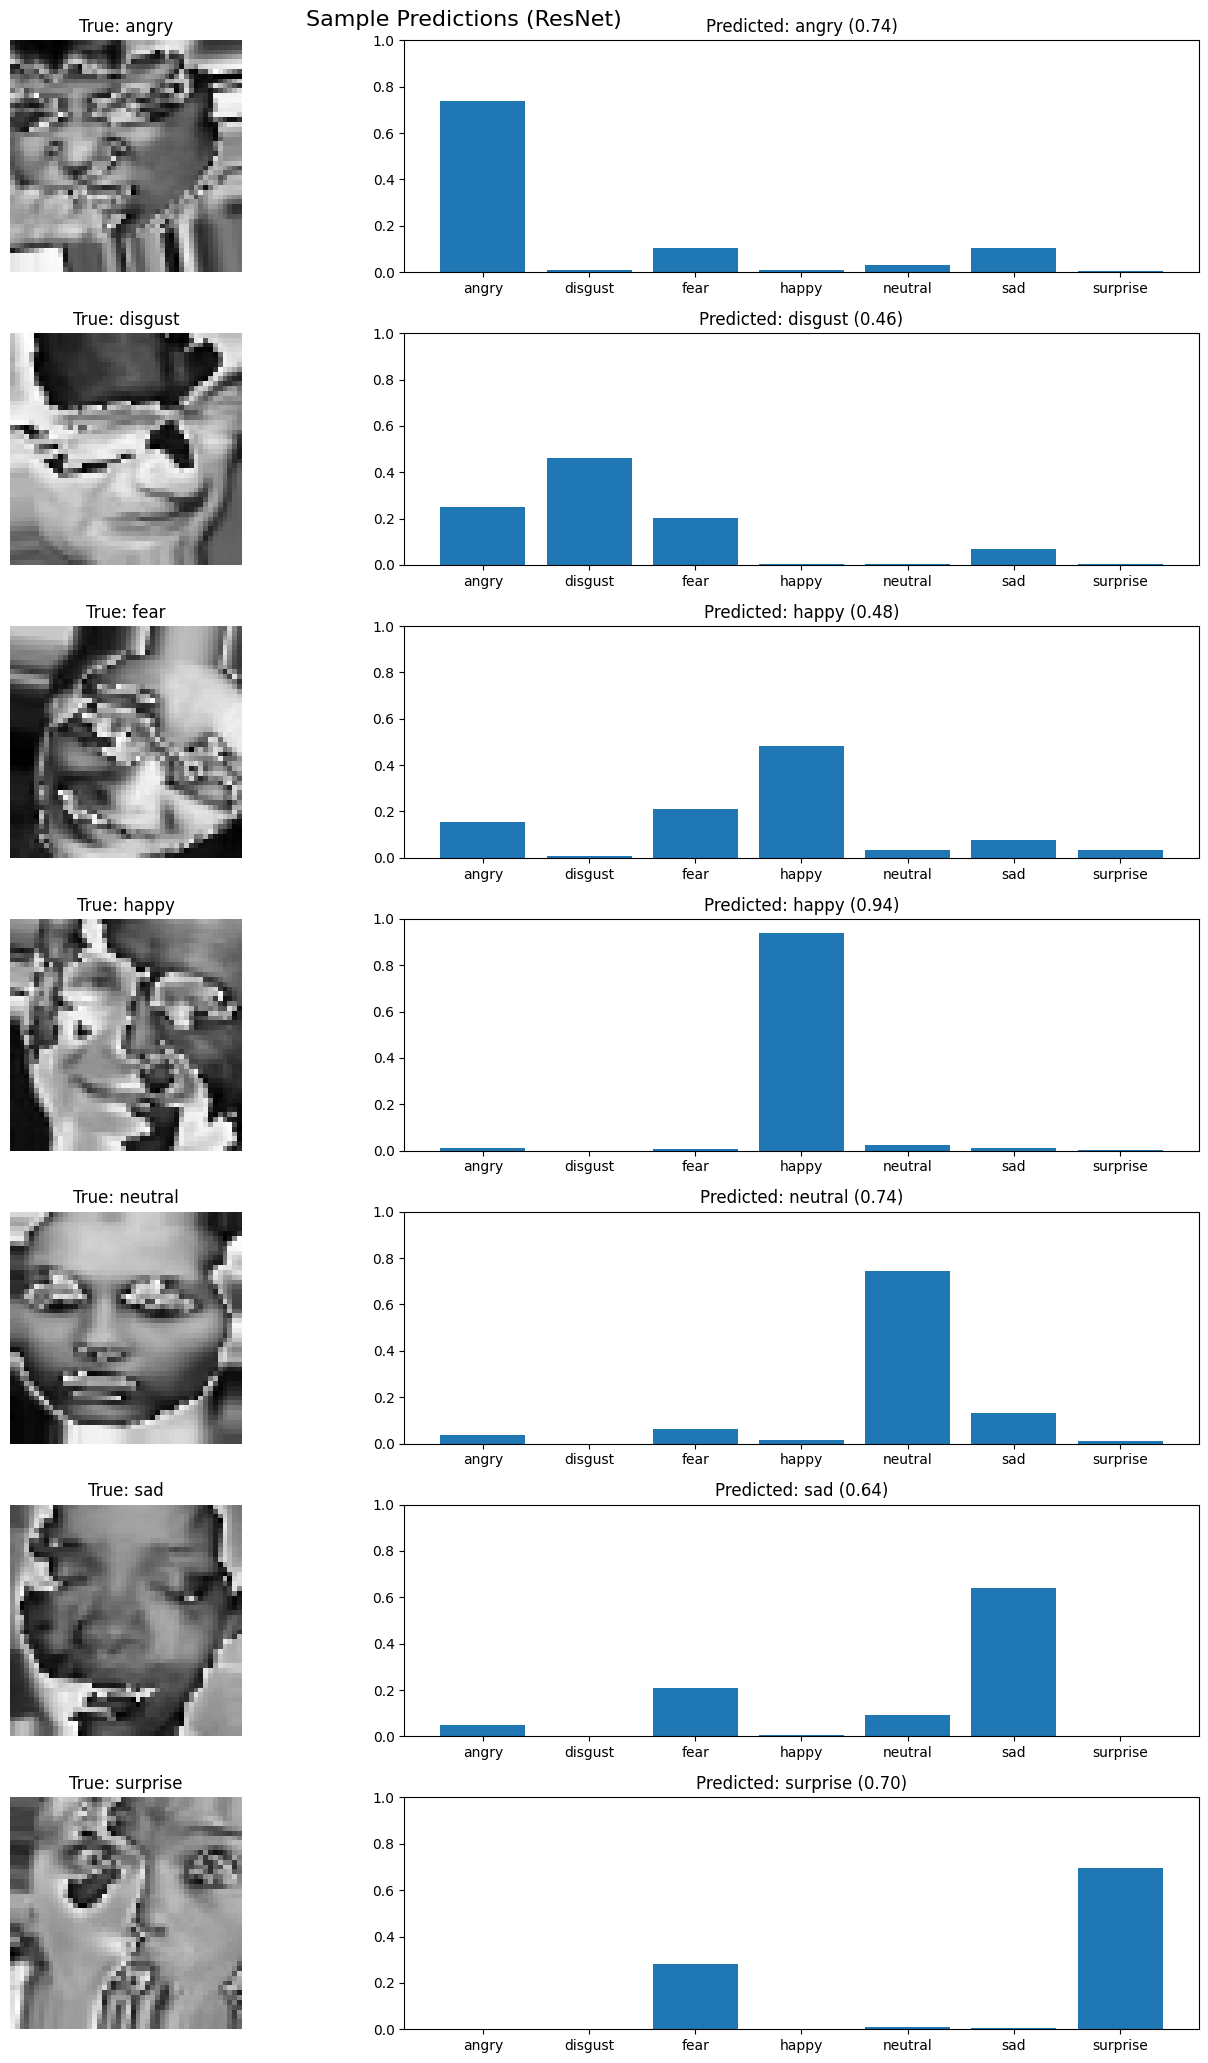

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


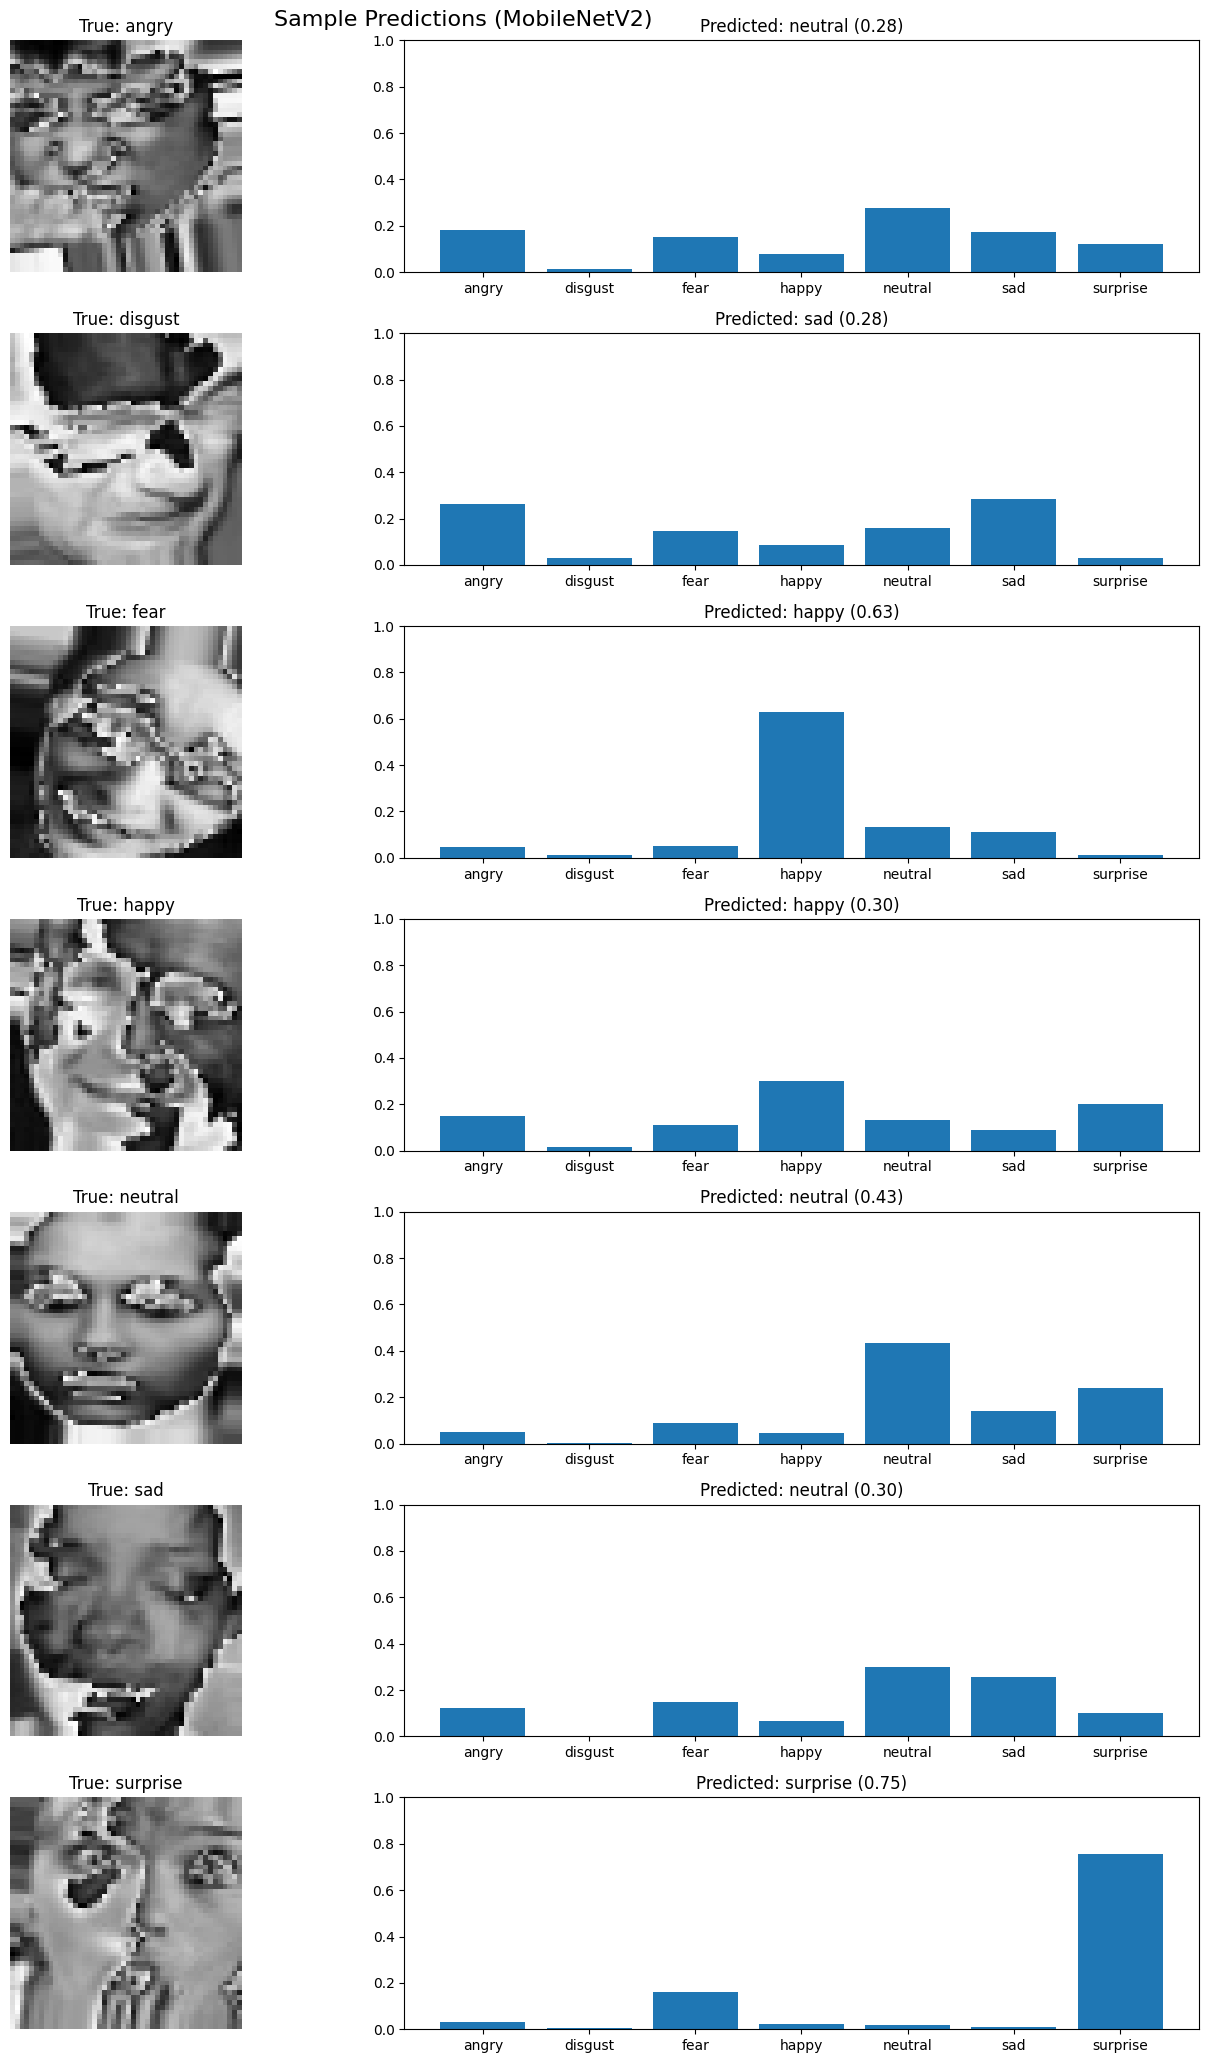

In [19]:
# Show a few test images with predictions for both models
sample_images = []
for emotion in EMOTION_CLASSES:
    emotion_dir = os.path.join('split_dataset/test', emotion)
    if os.path.exists(emotion_dir):
        image_files = os.listdir(emotion_dir)
        if image_files:
            sample_images.append(os.path.join(emotion_dir, image_files[0]))

def plot_sample_predictions(model, model_name):
    plt.figure(figsize=(15, 3 * len(sample_images)))
    for i, img_path in enumerate(sample_images):
        img = Image.open(img_path).resize((IMG_WIDTH, IMG_HEIGHT))
        img_array = np.array(img).astype('float32') / 255.0
        if img_array.ndim == 2:
            img_array = np.expand_dims(img_array, axis=-1)
        img_input = np.expand_dims(img_array, axis=0)
        pred = model.predict(img_input)
        pred_class = np.argmax(pred)
        plt.subplot(len(sample_images), 2, 2*i+1)
        plt.imshow(img_array.squeeze(), cmap='gray')
        plt.title(f"True: {os.path.basename(os.path.dirname(img_path))}")
        plt.axis('off')
        plt.subplot(len(sample_images), 2, 2*i+2)
        plt.bar(EMOTION_CLASSES, pred[0])
        plt.title(f"Predicted: {EMOTION_CLASSES[pred_class]} ({pred[0][pred_class]:.2f})")
        plt.ylim(0, 1)
    plt.suptitle(f"Sample Predictions ({model_name})", fontsize=16)
    plt.tight_layout()
    plt.show()

# For ResNet
plot_sample_predictions(best_resnet, "ResNet")

# For MobileNetV2
plot_sample_predictions(mobilenet_model, "MobileNetV2")